In [1]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import joblib
import datetime
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import pyupbit

2024-10-27 22:52:09.071751: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-27 22:52:09.327936: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-27 22:52:09.369559: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2024-10-27 22:52:09.369582: I tensorflow/compiler/xla/stream

In [2]:
coins = ['KRW-BIGTIME', 'KRW-CVC', 'KRW-DOGE', 'KRW-UXLINK', 'KRW-SOL', 'KRW-BTC', 'KRW-XRP', 'KRW-ETH', 'KRW-SXP']

In [3]:
len(coins)

9

In [4]:
interval = 'minute1'
count = 3126000

In [5]:
timestep = 1

In [6]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(timestep, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

2024-10-27 22:52:12.687737: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2024-10-27 22:52:12.687867: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2024-10-27 22:52:12.687963: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2024-10-27 22:52:12.690907: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.

KRW-BIGTIME model already exists
KRW-CVC model already exists
KRW-DOGE model already exists
KRW-UXLINK model already exists
KRW-SOL model already exists
KRW-BTC model already exists
KRW-XRP model already exists
KRW-ETH model does not exist
KRW-ETH data loaded
KRW-ETH train start
19538/19538 [==============================] - 74s 4ms/step
KRW-ETH Train RMSE: 6479.421519 Test RMSE: 10322.732493
1/1 [==============================] - 0s 52ms/step
KRW-ETH Actual [[3480000.]] Pred [[3470629.2]]
KRW-SXP model does not exist
KRW-SXP data loaded
KRW-SXP train start
10648/10648 [==============================] - 40s 4ms/step
KRW-SXP Train RMSE: 8.912356 Test RMSE: 4.037519
1/1 [==============================] - 0s 31ms/step
KRW-SXP Actual [[361.9]] Pred [[366.09015]]


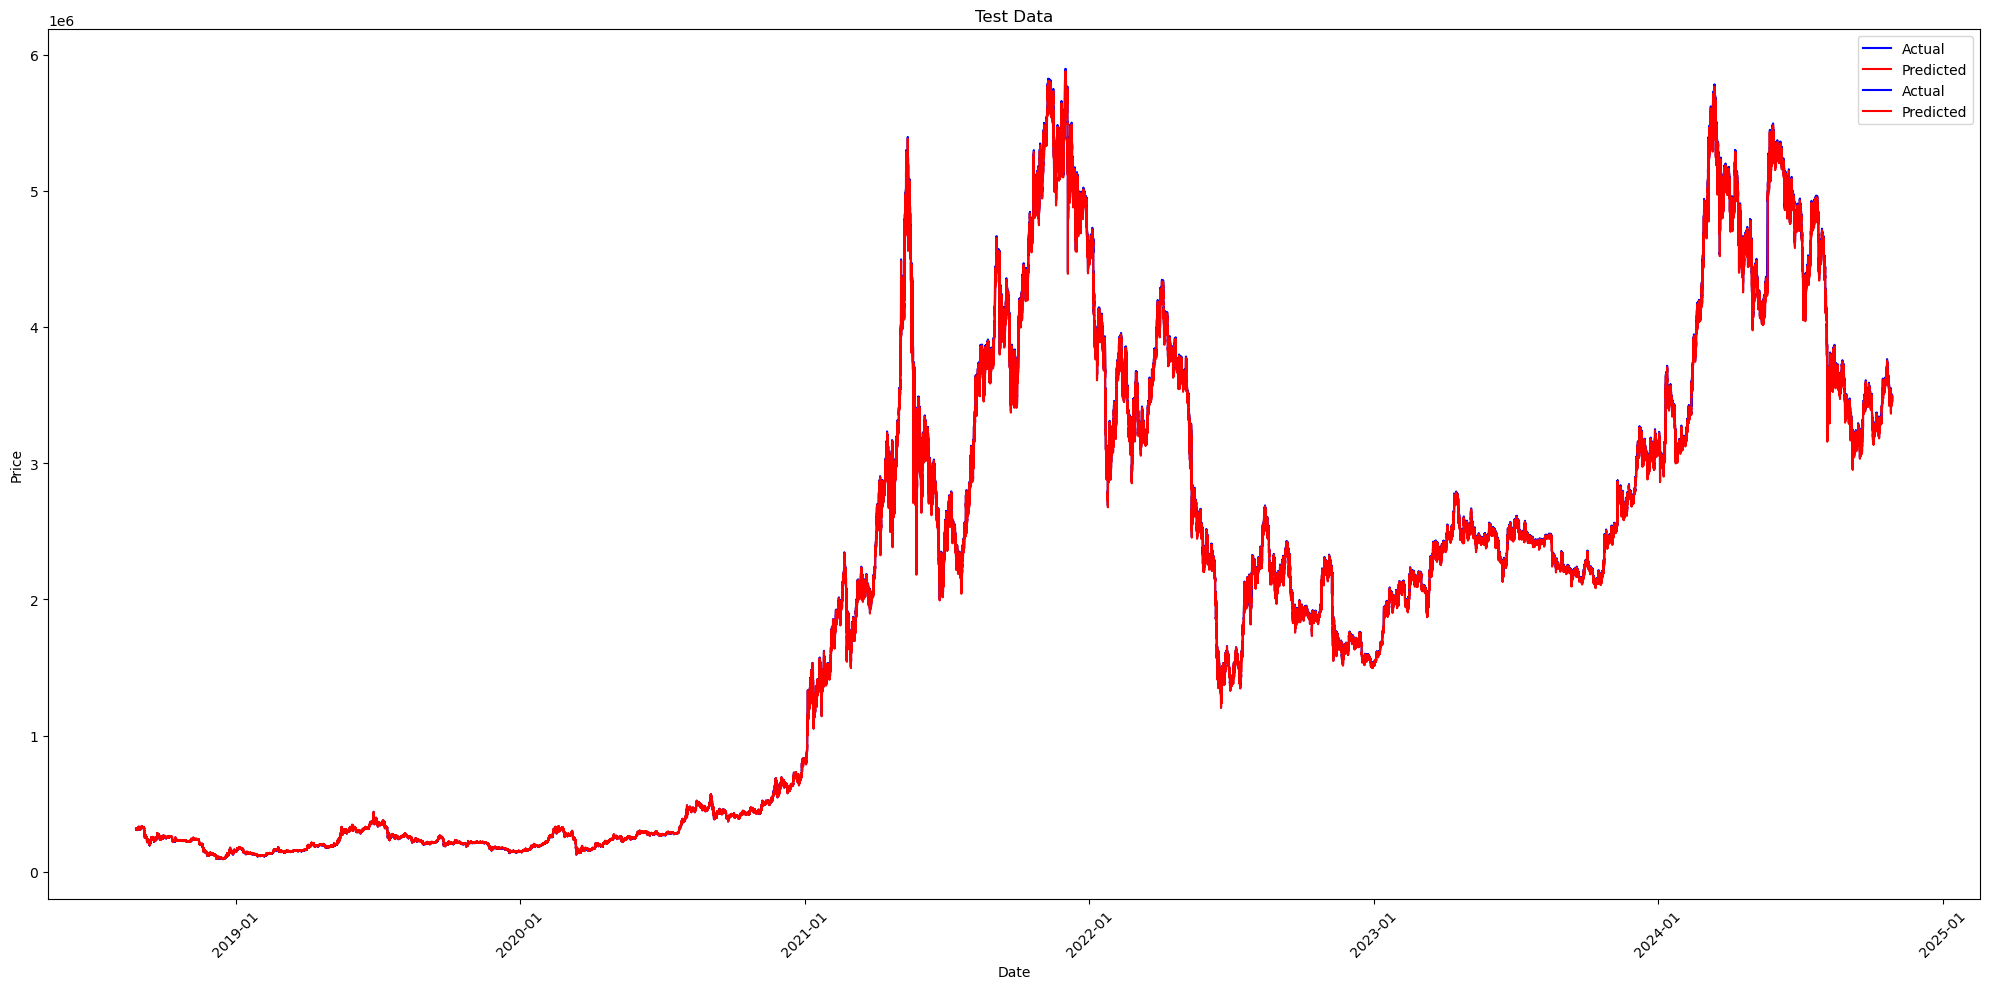

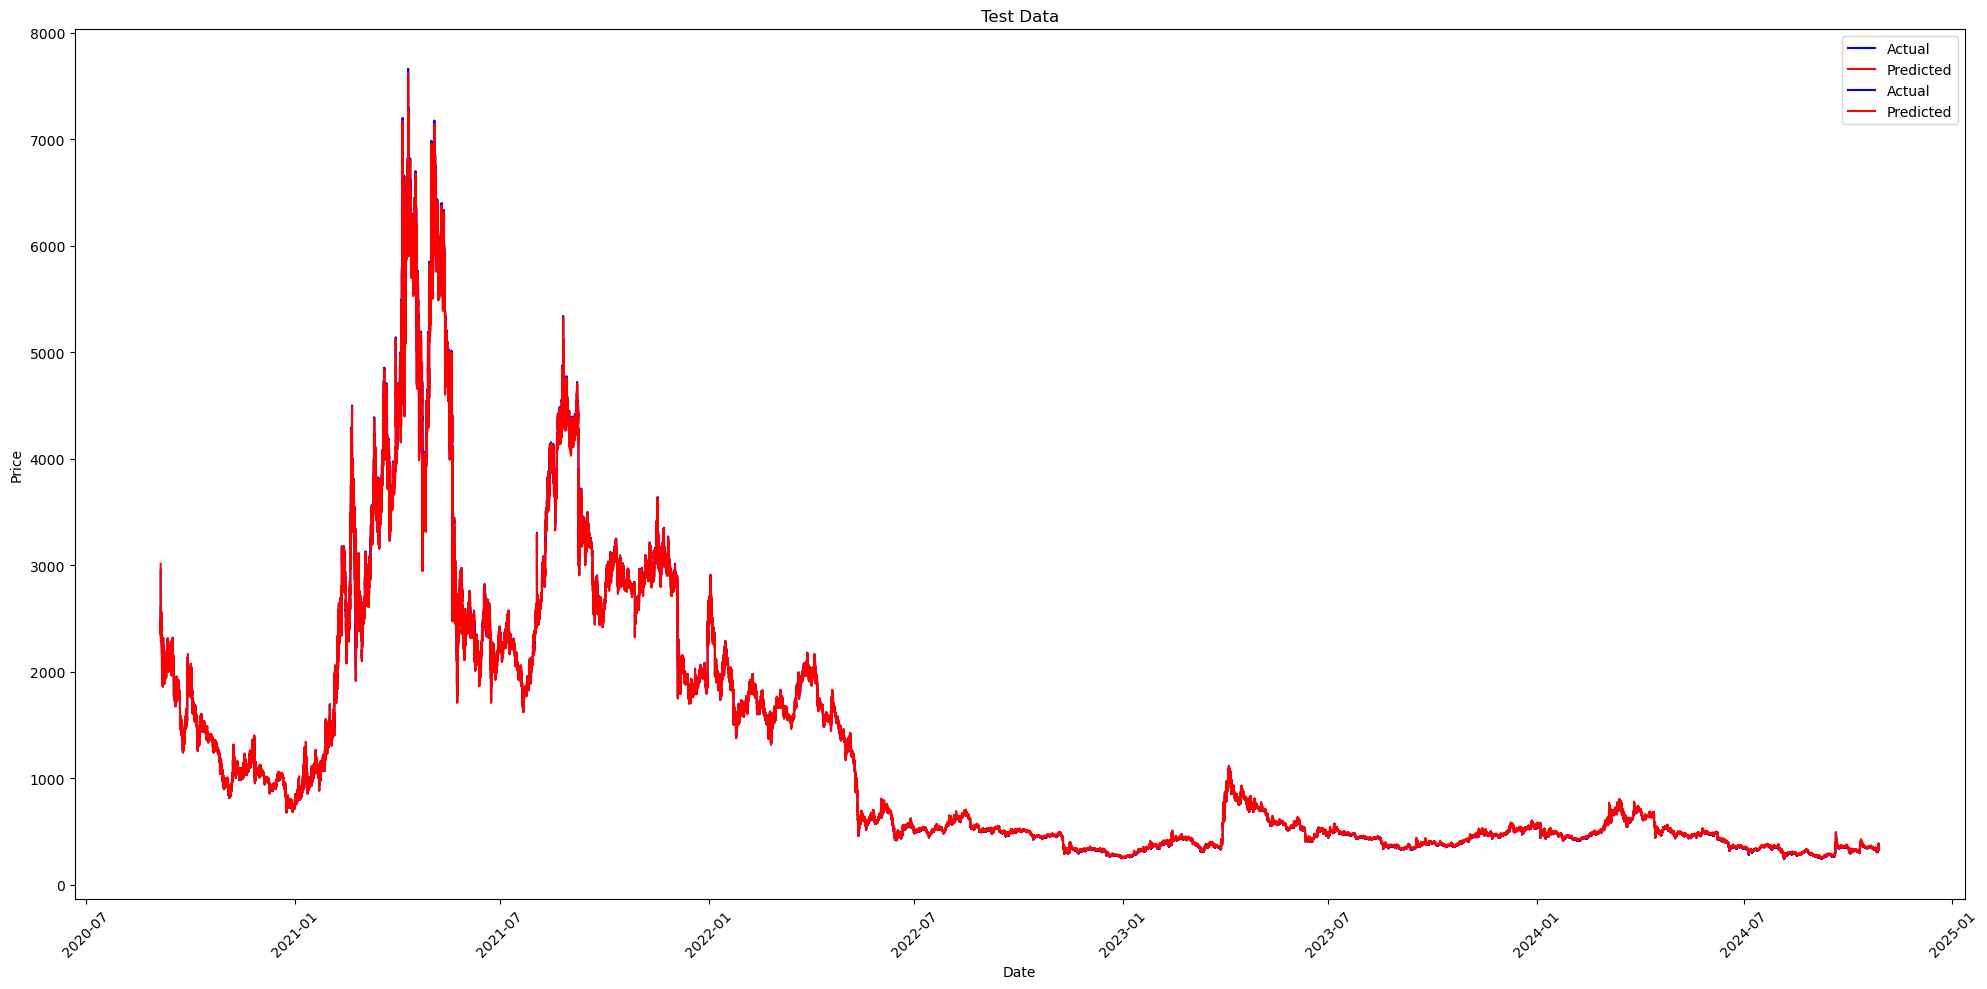

In [7]:
for ticker in coins:
    if os.path.exists(f'models/lstm_{ticker}.h5'):
        print(f'{ticker} model already exists')
        continue
    else:
        print(f'{ticker} model does not exist')
    
    if not os.path.exists(f'../data/from_pyupbit/{ticker}.csv'):
        now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        df = pyupbit.get_ohlcv(ticker, interval=interval, count=count).reset_index().rename(columns={'index': 'timestamp'})
        df.to_csv(f'../data/from_pyupbit/{ticker}.csv', index=False)
    else:
        df = pd.read_csv(f'../data/from_pyupbit/{ticker}.csv')
        
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
        
    print(f'{ticker} data loaded')
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))
    joblib.dump(scaler, f'models/{ticker}_scaler.pkl')
    
    X = []
    y = []
    for i in range(len(scaled_data) - timestep - 1):
        X.append(scaled_data[i:(i + timestep), 0])
        y.append(scaled_data[i + timestep, 0])
    
    X, y = np.array(X), np.array(y)
    
    train_size = int(len(X) * .8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    train_dates = df.index[:train_size]
    test_dates = df.index[train_size:]
    
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    
    print(f'{ticker} train start')
    
    model.fit(X_train, y_train, batch_size=32, epochs=20,
          validation_data=(X_test, y_test), callbacks=[early_stop], verbose=0)
    
    model.save(f'models/lstm_{ticker}.h5')
    
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    y_train = scaler.inverse_transform([y_train])
    y_test = scaler.inverse_transform([y_test])
    
    train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
    test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
    print(f'{ticker} Train RMSE: {train_score:.6f} Test RMSE: {test_score:.6f}')
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 1, 1)
    plt.plot(train_dates, y_train[0], label='Actual', color = 'Blue')
    plt.plot(train_dates, train_predict, label='Predicted', color = 'Red')
    plt.title('Train Data')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
    plt.savefig(f'results/{ticker}_train.png')
    
    plt.subplot(1, 1, 1)
    plt.plot(test_dates[:-2], y_test[0], label='Actual', color = 'Blue')
    plt.plot(test_dates[:-2], test_predict, label='Predicted', color = 'Red')
    plt.title('Test Data')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

    plt.tight_layout()
    plt.savefig(f'results/{ticker}_test.png')
    
    last_1_day = scaled_data[-timestep:]
    X_predict = last_1_day.reshape(1, timestep, 1)
    pred = model.predict(X_predict)
    pred = scaler.inverse_transform(pred)
    print(f'{ticker} Actual {scaler.inverse_transform(last_1_day)} Pred', pred)
    
    preds = []
    for i in range(30):
        pred = model.predict(X_predict, verbose=0)
        preds.append(scaler.inverse_transform(pred)[0][0])
        pred = pred.reshape(1, 1, 1)
        X_predict = np.append(X_predict[:, 1:, :], pred, axis=1).reshape(1, timestep, 1)